# Identifying Faces In A Single Movie

### By Wanga Mulaudzi
---
This notebook analyses 1k screengrabs from a single movie that is part of the cine_ethics dataset and identifies faces.

## Import statements

In [1]:
!pip install face_recognition

In [2]:
import cv2
import face_recognition
from google.colab.patches import cv2_imshow
from google.cloud import storage
from google.colab import auth
import io
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

RuntimeError: Error while calling cudaGetDevice(&the_device_id) in file /tmp/pip-install-ivgymjhg/dlib_e28a8dea1018439a92a61c695e6326c7/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version

## Loading the data
The data is in a bucket on google cloud so we can load the data into the notebook. First, we need to authorize the notebook to access the project.

In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=qQn4VvaD8X5ICt9NryoLHZuEoiSXES&prompt=consent&token_usage=remote&access_type=offline&code_challenge=5bsW4FooJXXgeJseJwAcgsv19JoFRJo9mZzUnLs8jYc&code_challenge_method=S256

Enter authorization code: 4/0AeaYSHDnqOzqHj6Keo1E0VcX4wbPpWV-4CXvL5m8ky-4K5pZqfCvA4qReDAYnqAz4OmYNw

You are now logged in as [w.m.mulaudzi@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set pr

In [2]:
# Authenticate google colab with google cloud resources
auth.authenticate_user()

In [3]:
# Log into the cine_ethics project
project_id = "ornate-lens-411311"
client = storage.Client(project=project_id)

bucket_name = "cine_ethics"
bucket = client.get_bucket(bucket_name)

In [4]:
# Name of the movie to analyse
movie = "Her (2013)"

# Path to the movie on the bucket
ai_movies_path = "data/resized_frames/" + movie

# Get blobs within the movie folder
blobs = bucket.list_blobs(prefix=ai_movies_path)

# Store the image path names
image_paths = []
image_arrays = []

# Load the pre-trained face detector model from Dlib
# detector = dlib.get_frontal_face_detector()

faces_list = []

for blob in blobs:
    # Append image path
    image_paths.append(blob.name)

    # Download the image as bytes
    img_bytes = blob.download_as_bytes()

    # Open the image
    img = Image.open(io.BytesIO(img_bytes))

    # Convert image to an array
    img = np.array(img)

    # Append array image to list
    image_arrays.append(img)

    # Convert image to grayscale (required for Haar cascades)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # detect the (x, y)-coordinates of the bounding boxes
    # corresponding to each face in the input image
    boxes = face_recognition.face_locations(rgb, model=args["cnn"])

    # Append the image with detected faces
    faces_list.append(img)

Now that the faces have been detected, we can group them using unsupervised learning.

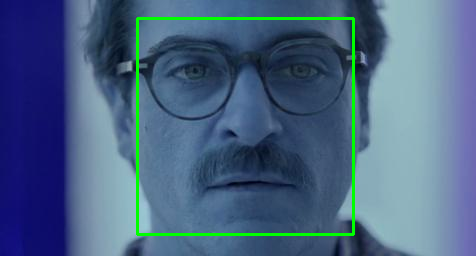

In [6]:
cv2_imshow(faces_list[0])